概要：本节使用SVM模型在mnist数据集上分类。

1.首先需要设置matplotlib绘图环境

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2.scikit有自带的mnist数据集，直接下载。

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

把数据集分为训练集和测试集，需要把图像乱序，否则训练效果不佳。

In [3]:
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

3.我们使用梯度下降算法，先把问题简化一下，测试两分类，也就是5和非5的情况。

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

4.测试一下效果。

In [7]:
some_digit = X[36000]
sgd_clf.predict([some_digit])

array([ True])

能够正确分类。

5.我们交叉验证一下分类器。

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

准确率达到了96%，是不是我们的模型已经足够好了呢。

6.下面来测试一个最笨的分类器，看看它的效果。

In [9]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

这个最笨的分类器准确率也有90%，说明是样本分布的问题，因为绝大多数样本都是非5，所以最笨的分类器也有很好的表现。

使用准确率来衡量分类器会有很大的问题，特别是样本分布有偏差的数据集，比如一种分类比另一种分类要多很多时。

7.使用混淆矩阵来评估分类器。

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred[0:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])

我们得到了训练集样本的预测值，然后和标签比较，产生混淆矩阵。

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

53417表示真反例（TN）,也就是非5的数字分类正确。

1162表示假正例（FP）,也就是非5的数字被识别成了5。

1350表示假反例（FN）,也就是5的数字被分类成了非5。

4071表示真正例（TP）,也就是5的数字分类正确。

8.准确率和召回率。

准确率=TP/(TP+FP)，召回率=TP/(FN+TP)

In [12]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7779476399770686

以上是准确率。

In [13]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

以上是召回率。

9.有些实例中要求准确率高，有些要求召回率高，两者不可兼得；下面我们画出召回率和准确率的曲线。

In [14]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [15]:
y_scores[0:10]

array([ -344482.72660078, -2207948.71399372,  -747234.78009357,
        -484767.20562804,  -468335.78059607,  -408939.5646945 ,
        -605512.48296772,  -259980.56489848,  -310147.38164882,
        -387143.33685258])

返回的是决策分数。

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

以上得到了阈值和召回率，准确率的关系值，每个阈值都对应不同的召回率和准确率。

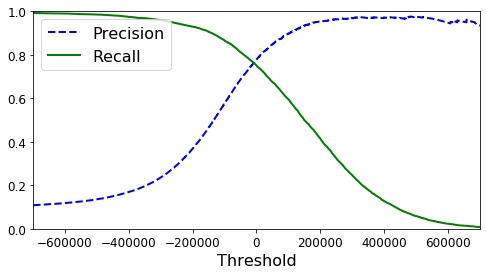

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

随着阈值的增大，准确率不断提高，召回率不断变小，需要找到平衡点。

10.下面观察准确率和召回率的关系。

In [16]:
(y_train_pred == (y_scores > 0)).all()

True

梯度下降算法默认阈值为0。

从上图可知，当准确率为90%时，阈值为70000，我们看看这时召回率是多少。

In [17]:
y_train_pred_90 = (y_scores > 70000)

In [18]:
precision_score(y_train_5, y_train_pred_90)

0.8712083540527101

In [19]:
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

我们看到，当准确率为90%时，召回率只有64%，这说明不能盲目的提高准确率。

11.观察准确率/召回率的曲线，评估模型的性能。

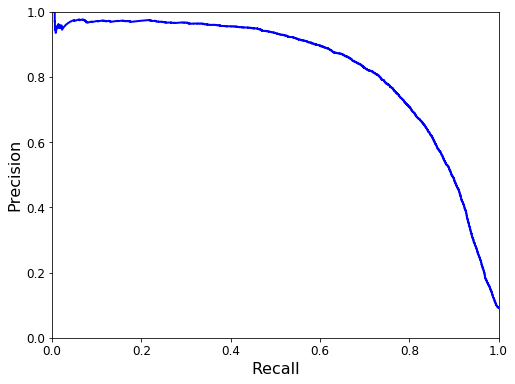

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

对于准确率/召回率曲线，曲线越靠近右上角越好，由上图可知，模型有很大的优化空间；该曲线应用正例较少或者假正例多于假反例的情况，其他的情况要用ROC曲线。

12.下面观察ROC曲线，就是准确率/(1-特异率)，其中特异率指的是反例样本被正确分类的比例。

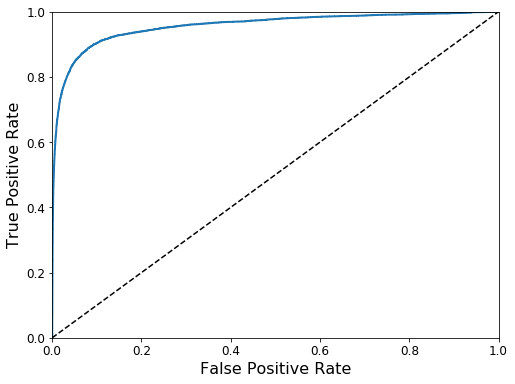

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

一个好的分类器的ROC曲线，越靠左上角越好。这是评价二分类模型的重要工具；

曲线下的面积越大，分类器越好。一个完美分类器的曲线面积为1。

In [23]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9562435587387078

比如我们的这个二分类问题，用ROC评估得到了很好的性能曲线，但这完全是因为5的样本比较少，观察PR曲线就可以知道
该模型有很大的改善空间。（PR曲线越靠近右上角越好）

13.试试随机森林，和梯度下降算法比较ROC曲线。

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_probas_forest

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

得到的是概率值，第一列是正例的概率，也就是为5的概率；把正例的概率作为决策分数计算ROC值。

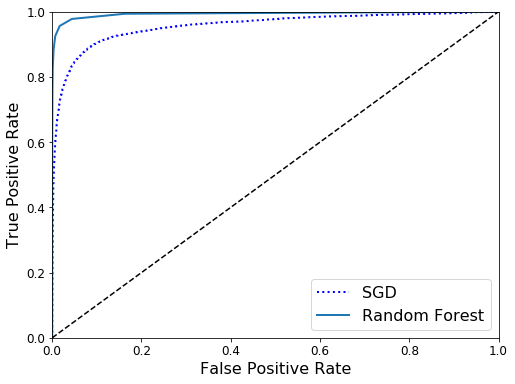

In [25]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

随机森林比SGD的ROC曲线好很多，更靠近左上角。

In [26]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [27]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

准确率和召回率都不错。

14.我们用支持向量机模型。

In [ ]:
from sklearn.svm import LinearSVC

lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

In [32]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.85375

准确率不高，我们标准化数据集。

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [35]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

d:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [49]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9211666666666667

准确率有提高。

In [50]:
from sklearn.svm import SVC

svm_clf = SVC(decision_function_shape="ovr", gamma="auto")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9461666666666667

In [ ]:
再试试另外的参数：

In [53]:
svm_clf2 = SVC(kernel="poly", degree=3, coef0=1, C=5)
svm_clf2.fit(X_train_scaled[:10000], y_train[:10000])

d:\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=5, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [55]:
y_pred = svm_clf2.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9608833333333333

进行参数搜索：

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=2.2350452844489768, gamma=0.0014636566224776645 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=2.2350452844489768, gamma=0.0014636566224776645, total=   0.4s
[CV] C=2.2350452844489768, gamma=0.0014636566224776645 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  C=2.2350452844489768, gamma=0.0014636566224776645, total=   0.4s
[CV] C=2.2350452844489768, gamma=0.0014636566224776645 ...............
[CV]  C=2.2350452844489768, gamma=0.0014636566224776645, total=   0.4s
[CV] C=5.018902332387908, gamma=0.05957167873858634 ..................
[CV] ... C=5.018902332387908, gamma=0.05957167873858634, total=   0.7s
[CV] C=5.018902332387908, gamma=0.05957167873858634 ..................
[CV] ... C=5.018902332387908, gamma=0.05957167873858634, total=   0.7s
[CV] C=5.018902332387908, gamma=0.05957167873858634 ..................
[CV] ... C=5.018902332387908, gamma=0.05957167873858634, total=   0.7s
[CV] C=9.55269519672093, gamma=0.013182136929486901 ..................
[CV] ... C=9.55269519672093, gamma=0.013182136929486901, total=   0.6s
[CV] C=9.55269519672093, gamma=0.013182136929486901 ..................
[CV] ... C=9.55269519672093, gamma=0.013182136929486901, total=   0.6s
[CV] C=9.55269519672093, gamma=0.013182136929486901 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=5, cache_size=200, class_weight=None,
                                 coef0=1, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='poly', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000004D60E550>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000532EBA8>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [57]:
rnd_search_cv.best_estimator_

SVC(C=4.011565009767059, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=0.0028460056431216596,
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [58]:
rnd_search_cv.best_estimator_.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=4.011565009767059, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=0.0028460056431216596,
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [59]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9647333333333333

In [ ]:
准确率还是不错的。